# # Exploratory Data Analysis Part-1

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#### Loading Dataset

In [2]:
final_df=pd.read_parquet('final_data.parquet')
final_df.shape

(17311807, 32)

## Analysis Begins...

### In-Depth Inventory Analysis

#### ABC Segmentation

In [4]:
date_columns = [
    'order_purchase_timestamp', 'order_approved_at', 
    'order_delivered_carrier_date', 'order_delivered_customer_date', 
    'order_estimated_delivery_date'
]
for col in date_columns:
    final_df[col] = pd.to_datetime(final_df[col], errors='coerce')

# Create the 'revenue' column for inventory analysis
final_df['revenue'] = final_df['price'] + final_df['freight_value']

In [5]:
catg_rev=final_df.groupby('product_category_name_english')['revenue'].sum().reset_index()

catg_rev=catg_rev.sort_values(by='revenue',ascending=False)

total_rev=catg_rev['revenue'].sum()
catg_rev['cumulative_percentage']=(catg_rev['revenue'].cumsum()/total_rev)*100

def classify_abc(percentage):
    if percentage <= 80:
        return 'A'  # Vital few
    elif 80 < percentage <= 95:
        return 'B'  # Important but not critical
    else:
        return 'C'  # Trivial many

catg_rev['abc_category']=catg_rev['cumulative_percentage'].apply(classify_abc)

abc_summary=catg_rev['abc_category'].value_counts()
print("--- ABC Analysis Summary ---")
print(abc_summary)

--- ABC Analysis Summary ---
abc_category
C    39
A    16
B    16
Name: count, dtype: int64


#### Dead Stock Analysis

In [6]:
last_sale_date=final_df.groupby('product_id')['order_purchase_timestamp'].max().reset_index()
six_months_ago=final_df['order_purchase_timestamp'].max()-pd.DateOffset(months=6)
dead_stock_products=last_sale_date[last_sale_date['order_purchase_timestamp']<six_months_ago]
print(f"Found {len(dead_stock_products)} products with no sales in the last 6 months.")
print(dead_stock_products)

Found 15080 products with no sales in the last 6 months.
                             product_id order_purchase_timestamp
1      00088930e925c41fd95ebfe695fd2655      2017-12-12 19:20:28
2      0009406fd7479715e4bef61dd91f2462      2017-12-21 16:21:47
5      0011c512eb256aa0dbbb544d8dffcf6e      2017-12-14 20:30:29
6      00126f27c813603687e6ce486d909d01      2017-09-17 20:45:13
7      001795ec6f1b187d37335e1c4704762e      2017-12-27 00:22:18
...                                 ...                      ...
31419  ffe9468f4d890db80b7231e86931ff37      2017-11-20 22:30:23
31420  ffeb228c521d5464d1f71444da96c446      2018-02-06 09:48:11
31423  fff0a542c3c62682f23305214eaeaa24      2017-12-05 09:03:19
31426  fff6177642830a9a94a0f2cba5e476d1      2017-09-03 11:38:54
31428  fff9553ac224cec9d15d49f5a263411f      2017-10-06 16:44:05

[15080 rows x 2 columns]


#### Product Portfolio Analysis (The BCG Matrix)

In [7]:
product_portfolio=final_df.groupby('product_category_name_english').agg(
    total_revenue=('revenue','sum'),
    total_orders=('order_id','nunique')
).dropna()

revenue_threshold=product_portfolio['total_revenue'].quantile(0.75)
orders_threshold=product_portfolio['total_orders'].quantile(0.75)

conditions=[
    (product_portfolio['total_revenue']>revenue_threshold) & (product_portfolio['total_orders'] > orders_threshold),
    (product_portfolio['total_revenue']<=revenue_threshold) & (product_portfolio['total_orders'] > orders_threshold),
    (product_portfolio['total_revenue']>revenue_threshold) & (product_portfolio['total_orders'] <= orders_threshold)
]
choices = ['Stars', 'Traffic Drivers', 'Niche Winners']
product_portfolio['quadrant'] = np.select(conditions, choices, default='Underperformers')

fig = px.scatter(
    data_frame=product_portfolio,
    x='total_revenue',
    y='total_orders',
    color='quadrant',  
    hover_name=product_portfolio.index, 
    size='total_revenue', 
    size_max=50,
    color_discrete_map={ 
        'Stars': 'green',
        'Traffic Drivers':'orange',
        'Niche Winners':'blue',
        'Underperformers':'red'
    },
    template='plotly_white'
)

fig.add_hline(
    y=orders_threshold,
    line_dash="dash",
    line_color="grey"
)
fig.add_vline(
    x=revenue_threshold,
    line_dash="dash",
    line_color="grey"
)

fig.update_layout(
    title_text='<b>Product Portfolio Analysis (BCG Matrix Style)</b>',
    title_x=0.5, # Center the title
    xaxis_title='Total Revenue',
    yaxis_title='Total Orders',
    legend_title='<b>Quadrant</b>',
    font=dict(family="Arial, sans-serif", size=12)
)

fig.show()

#### Sales Velocity & Consistency

In [8]:
final_df['purchase_month']=final_df['order_purchase_timestamp'].dt.to_period('M')
monthly_sales=final_df.groupby(['product_category_name_english','purchase_month'])['order_id'].nunique().reset_index()
cat_vel=monthly_sales.groupby('product_category_name_english')['order_id'].agg(['mean', 'std']).reset_index()
cat_vel['consistency_ratio']=cat_vel['std']/cat_vel['mean']
print("\n--- Sales Velocity & Consistency (Top 5 Most Consistent) ---")
print(cat_vel.sort_values(by='consistency_ratio', ascending=True).head())


--- Sales Velocity & Consistency (Top 5 Most Consistent) ---
   product_category_name_english        mean         std  consistency_ratio
61         security_and_services    1.000000    0.000000           0.000000
29     fashion_childrens_clothes    1.166667    0.408248           0.349927
63              small_appliances   30.150000   11.694691           0.387884
34               fixed_telephony    9.904762    3.998809           0.403726
39               furniture_decor  297.142857  121.884899           0.410190


#### Geographic Sales Hotspots

In [9]:
category_focus='computers_accessories'
category_df=final_df[final_df['product_category_name_english']==category_focus]
state_hotspots=category_df['customer_state'].value_counts(normalize=True).head(5)*100
print(f"\n--- Top 5 Sales Hotspots for {category_focus} ---")
print(state_hotspots)


--- Top 5 Sales Hotspots for computers_accessories ---
customer_state
SP    34.346396
MG    20.022798
RJ    19.988031
RS     6.561363
PR     4.162060
Name: proportion, dtype: float64


#### Price Point Analysis

In [10]:
final_df['price_bin']=pd.cut(final_df['price'],bins=[0, 50, 100, 200, 500, 5000],labels=['0-50','50-100','100-200','200-500','500+'])
price_analysis=final_df.groupby('price_bin',observed=False)['revenue'].sum()
print("\n--- Total Revenue by Price Bin ---")
print(price_analysis)


--- Total Revenue by Price Bin ---
price_bin
0-50       2.777094e+08
50-100     4.741280e+08
100-200    6.859723e+08
200-500    5.093773e+08
500+       4.800701e+08
Name: revenue, dtype: float64


### Logistics Analysis

#### Root Cause of Delays

In [11]:
# Processing time and shipping time in days
final_df['proc_time']=(final_df['order_delivered_carrier_date']-final_df['order_approved_at']).dt.days
final_df['ship_time']=(final_df['order_delivered_customer_date']-final_df['order_delivered_carrier_date']).dt.days

# Determining if an order was delivered late
final_df['is_late']=np.where(final_df['order_delivered_customer_date']>final_df['order_estimated_delivery_date'],1,0)

# Analyzing the avg times and late rate for each state
state_delay_analysis=final_df.groupby('customer_state').agg(
    avg_proc_time=('proc_time','mean'),
    avg_ship_time=('ship_time','mean'),
    late_delivery_rate=('is_late','mean')
).reset_index()

# Convert late rate to a percentage
state_delay_analysis['late_delivery_rate']=state_delay_analysis['late_delivery_rate']*100

# Display the top 5 states with the highest late delivery rate
print("\n--- Top 5 States with Highest Late Delivery Rate ---")
print(state_delay_analysis.sort_values(by='late_delivery_rate',ascending=False,ignore_index=True).head())


--- Top 5 States with Highest Late Delivery Rate ---
  customer_state  avg_proc_time  avg_ship_time  late_delivery_rate
0             AL       2.234370      20.064862           22.748067
1             MA       2.615825      16.797773           20.567738
2             CE       2.362806      17.306181           16.447009
3             PI       2.091770      15.138524           15.649150
4             SE       2.486279      17.648162           14.941934


#### Seller Performance Scorecard

In [12]:
# Seller's average processing time and total orders
seller_scorecard = final_df.groupby('seller_id').agg(
    avg_processing_time=('proc_time', 'mean'),
    total_orders=('order_id', 'nunique')
).reset_index()

# Sellers with more than 10 orders
seller_scorecard = seller_scorecard[seller_scorecard['total_orders'] > 10]

# Top 5 Fastest and Slowest Sellers
print("\n--- Top 5 Fastest Sellers (Lowest Avg Proc Time) ---")
print(seller_scorecard.sort_values(by='avg_processing_time', ascending=True).head())

print("\n--- Top 5 Slowest Sellers (Highest Avg Proc Time) ---")
print(seller_scorecard.sort_values(by='avg_processing_time', ascending=False).head())


--- Top 5 Fastest Sellers (Lowest Avg Proc Time) ---
                             seller_id  avg_processing_time  total_orders
1683  916c9de0b5ad957346eeeb12f332687e            -1.022817            22
2226  c3e1abd72a42fe690fcd89cf5720fe29            -0.501855            13
1264  6ddc28b61be28373b4503a1f61cf98a9            -0.335179            11
1376  768a86e36ad6aae3d03ee3c6433d61df            -0.214577            17
576   334cab711dee080b079fa5779b584783            -0.212262            11

--- Top 5 Slowest Sellers (Highest Avg Proc Time) ---
                             seller_id  avg_processing_time  total_orders
2693  ecccfa2bb93b34a3bf033cc5d1dcdc69            19.524644            11
1187  66e0557ecc2b4dbea057e93f215f68d8            18.721323            30
981   54965bbe3e4f07ae045b90b0b8541f52            18.067316            69
915   5058e8c1e82653974541e83690655b4a            15.118973            59
2786  f4c4daa86e30c7e5a553a8d518ac03a5            14.496502            16


#### Analyzing the "Long Tail" of Delays

--- Comparison of Top States: Overall vs. Severely Late Orders ---
                Overall % of Orders  Severely Late % of Orders
customer_state                                                
SP                            37.37                      17.90
RJ                            19.91                      42.12
MG                            19.12                      11.01
RS                             5.42                       5.10
PR                             4.15                       1.94
SC                             3.55                       4.63
BA                             2.45                       5.03
ES                             2.04                       2.97
GO                             0.89                       0.00
MT                             0.85                       0.00
CE                             0.00                       1.27
PE                             0.00                       1.10


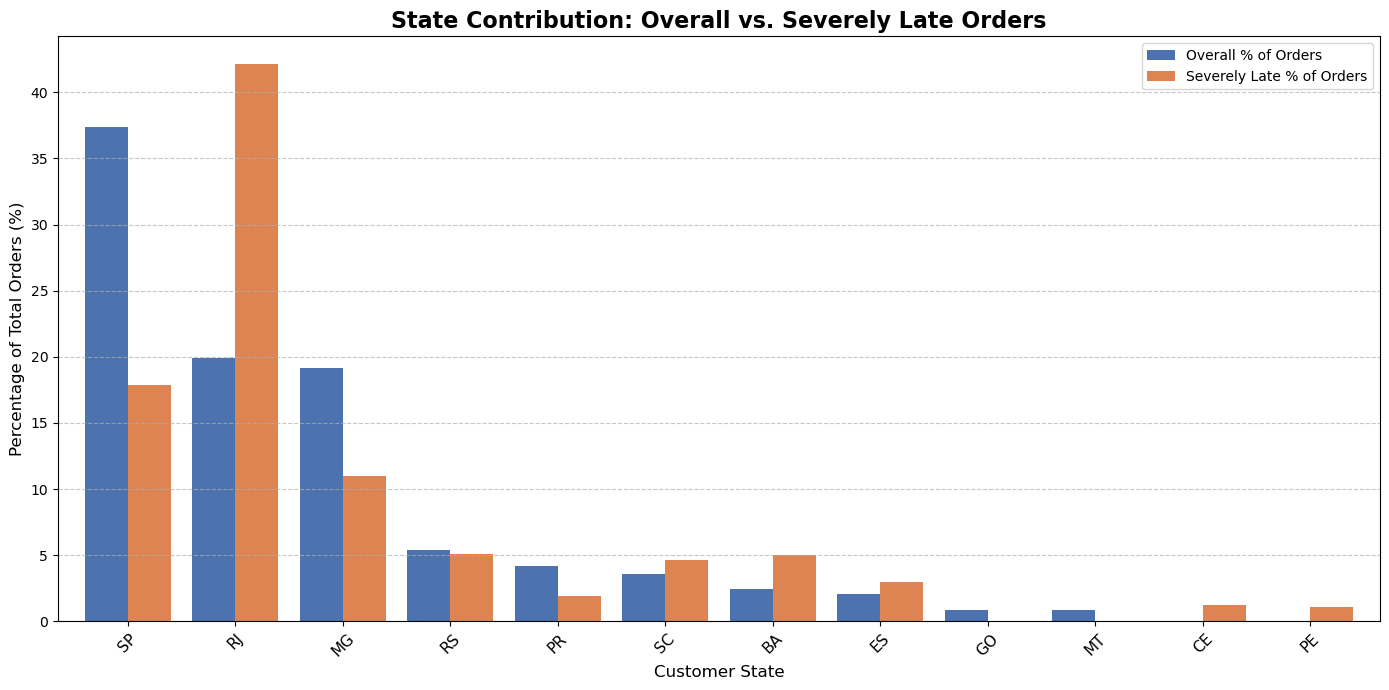

In [13]:
final_df['delivery_delta']=(final_df['order_estimated_delivery_date']-final_df['order_delivered_customer_date']).dt.days

overall_state_dist = (
    final_df['customer_state']
    .value_counts(normalize=True)
    .head(10)
    .mul(100)
    .rename('Overall % of Orders')
)

late_state_dist = (
    final_df.query('delivery_delta < -7')['customer_state']
    .value_counts(normalize=True)
    .head(10)
    .mul(100)
    .rename('Severely Late % of Orders')
)

comparison_df=pd.concat([overall_state_dist, late_state_dist], axis=1, join='outer').fillna(0)

print("--- Comparison of Top States: Overall vs. Severely Late Orders ---")
print(comparison_df.round(2))

ax = comparison_df.plot(
    kind='bar',
    figsize=(14, 7),
    width=0.8,
    color=['#4C72B0', '#DD8452']
)

ax.set_title('State Contribution: Overall vs. Severely Late Orders', fontsize=16, weight='bold')
ax.set_ylabel('Percentage of Total Orders (%)', fontsize=12)
ax.set_xlabel('Customer State', fontsize=12)
ax.tick_params(axis='x', rotation=45, labelsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### Delivery Promise Accuracy

In [14]:
final_df['delivery_delta']=(final_df['order_estimated_delivery_date']-final_df['order_delivered_customer_date']).dt.days
print(f"\nAverage Delivery Delta: {final_df['delivery_delta'].mean():.2f} days")
print(f"Percentage of orders arriving early: { (final_df['delivery_delta'] > 0).mean() * 100 :.2f}%")


Average Delivery Delta: 11.35 days
Percentage of orders arriving early: 91.25%


#### Weekend Effect on Proc Time

In [15]:
final_df['purchase_day_of_week'] = final_df['order_purchase_timestamp'].dt.day_name()
weekend_effect = final_df.groupby('purchase_day_of_week')['proc_time'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
print("\n--- Average Seller Processing Time by Purchase Day ---")
print(weekend_effect)


--- Average Seller Processing Time by Purchase Day ---
purchase_day_of_week
Monday       1.800717
Tuesday      2.010995
Wednesday    2.152266
Thursday     2.571686
Friday       3.367548
Saturday     2.851703
Sunday       1.946035
Name: proc_time, dtype: float64


#### Impact of Product Size/Weight on Delivery

In [16]:
print("\n--- Correlation between Product Weight and Shipping Time ---")
print(final_df[['product_weight_g', 'ship_time']].corr())


--- Correlation between Product Weight and Shipping Time ---
                  product_weight_g  ship_time
product_weight_g          1.000000   0.031671
ship_time                 0.031671   1.000000


#### Most Common (and Problematic) Shipping Routes

In [17]:
final_df['shipping_route']=final_df['seller_state'] + ' -> ' + final_df['customer_state']
route_performance=final_df.groupby('shipping_route').agg(
    total_orders=('order_id', 'nunique'),
    late_rate=('is_late', 'mean')
).reset_index()
print("\n--- Top 5 Most Problematic High-Volume Shipping Routes ---")
print(route_performance[route_performance['total_orders']>100].sort_values(by='late_rate',ascending=False).head())


--- Top 5 Most Problematic High-Volume Shipping Routes ---
    shipping_route  total_orders  late_rate
384       SP -> AL           251   0.237755
392       SP -> MA           481   0.231424
142       MA -> SP           123   0.226497
399       SP -> PI           317   0.171949
407       SP -> SE           207   0.171286


#### Late Delivery vs. Review Score

In [18]:

review_impact=final_df.groupby('is_late')['review_score'].mean()
print("\n--- Average Review Score for On-Time vs. Late Deliveries ---")
print(review_impact)


--- Average Review Score for On-Time vs. Late Deliveries ---
is_late
0    4.208052
1    2.455777
Name: review_score, dtype: float64


#### Payment Type vs. Processing Time

In [19]:
payment_impact = final_df.groupby('payment_type')['proc_time'].mean()
print("\n--- Average Processing Time by Payment Type ---")
print(payment_impact.sort_values(ascending=False))


--- Average Processing Time by Payment Type ---
payment_type
voucher        2.447077
boleto         2.396797
credit_card    2.347242
debit_card     2.248529
Name: proc_time, dtype: float64


#### Churn Risk Analysis

In [20]:
cust_orders=final_df.groupby('customer_unique_id')['order_id'].nunique()
repeat_cust=cust_orders[cust_orders>1].index
repeat_cust_df=final_df[final_df['customer_unique_id'].isin(repeat_cust)]
churn_risk=repeat_cust_df.groupby('customer_unique_id')['is_late'].sum().reset_index()
at_risk_cust=churn_risk[churn_risk['is_late']>0]
print(f"\nFound {len(at_risk_cust)} repeat customers who have experienced at least one late delivery.")


Found 333 repeat customers who have experienced at least one late delivery.


#### Profitability Analysis by Category

In [21]:
# --- Profitability Proxy ---
final_df['profit_proxy']=final_df['price']-final_df['freight_value']
category_profit=final_df.groupby('product_category_name_english')['profit_proxy'].sum().sort_values(ascending=False)
print("\n--- Top 5 Most Profitable Categories (Price - Freight) ---")
print(category_profit.head())


--- Top 5 Most Profitable Categories (Price - Freight) ---
product_category_name_english
health_beauty            1.610630e+08
watches_gifts            1.589395e+08
bed_bath_table           1.432432e+08
sports_leisure           1.332276e+08
computers_accessories    1.185356e+08
Name: profit_proxy, dtype: float64


### Financial & Revenue Analysis 

#### Day-of-Week Revenue

<Axes: title={'center': 'Total Revenue by Day of Week'}, xlabel='purchase_day_of_week'>

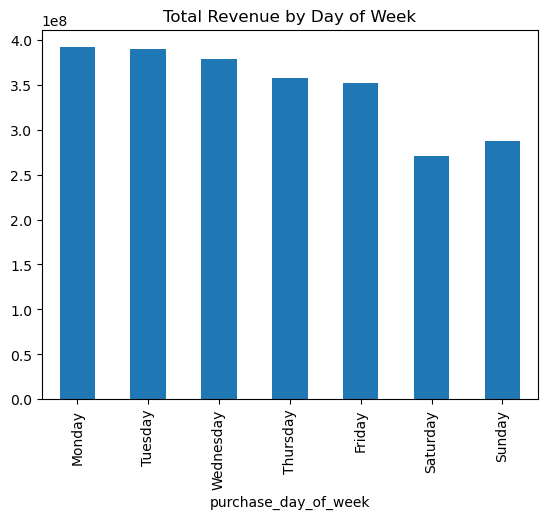

In [22]:
final_df['purchase_day_of_week']=final_df['order_purchase_timestamp'].dt.day_name()
daily_revenue = final_df.groupby('purchase_day_of_week')['revenue'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
daily_revenue.plot(kind='bar', title='Total Revenue by Day of Week')

#### Average Order Value Trend 

<Axes: title={'center': 'Monthly Average Order Value (AOV)'}, xlabel='purchase_month'>

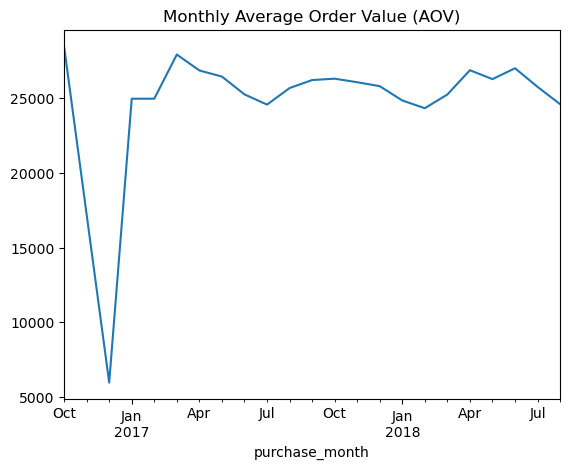

In [23]:
final_df['purchase_month']=final_df['order_purchase_timestamp'].dt.to_period('M')
monthly_aov = final_df.groupby('purchase_month').agg(
    total_revenue=('revenue', 'sum'),
    total_orders=('order_id', 'nunique')
)
monthly_aov['aov']=monthly_aov['total_revenue'] / monthly_aov['total_orders']
monthly_aov['aov'].plot(kind='line', title='Monthly Average Order Value (AOV)')

#### Unprofitable Orders

In [24]:
unprofitable_orders=final_df[final_df['freight_value']>final_df['price']]
print(f"\nFound {len(unprofitable_orders)} orders where freight cost exceeded item price.")

unprofitable_by_cat = unprofitable_orders['product_category_name_english'].value_counts().head(5)
print("\n--- Top 5 Categories for Unprofitable Orders ---")
print(unprofitable_by_cat)


Found 602615 orders where freight cost exceeded item price.

--- Top 5 Categories for Unprofitable Orders ---
product_category_name_english
electronics        86572
housewares         63697
furniture_decor    56918
telephony          49920
health_beauty      43466
Name: count, dtype: int64


#### High-Value Customer Revenue

In [25]:
cust_rev=final_df.groupby('customer_unique_id')['revenue'].sum()
# Define top 10% of customers as high-value
top_10_percent_threshold=cust_rev.quantile(0.90)
high_value_customers_revenue=cust_rev[cust_rev>=top_10_percent_threshold].sum()
total_revenue=final_df['revenue'].sum()
percentage_from_top_10=(high_value_customers_revenue/total_revenue)*100
print(f"\nThe top 10% of customers account for {percentage_from_top_10:.2f}% of total revenue.")


The top 10% of customers account for 52.04% of total revenue.


#### Top 10 Revenue Generating Cities

In [26]:
city_revenue=final_df.groupby('customer_city')['revenue'].sum().sort_values(ascending=False).head(10)
print("\n--- Top 10 Revenue Generating Cities ---")
print(city_revenue)


--- Top 10 Revenue Generating Cities ---
customer_city
rio de janeiro    3.176592e+08
sao paulo         1.952178e+08
belo horizonte    1.116138e+08
niteroi           8.519020e+07
curitiba          3.995127e+07
santos            3.725876e+07
porto alegre      3.565464e+07
salvador          3.203366e+07
uberlandia        3.033953e+07
campinas          2.570801e+07
Name: revenue, dtype: float64


### Customer Behavior & Segmentation

#### New vs. Returning Customers

In [27]:
final_df['is_returning'] = final_df.duplicated(subset=['customer_unique_id'], keep='first')
customer_type_analysis = final_df.groupby('is_returning')['revenue'].agg(['mean', 'count'])
print("\n--- Spending Habits: New vs. Returning Customers ---")
print(customer_type_analysis)


--- Spending Habits: New vs. Returning Customers ---
                    mean     count
is_returning                      
False         145.909045     91217
True          140.218726  17220590


#### First Purchase Analysis

In [28]:
first_purchase_df = final_df.drop_duplicates(subset=['customer_unique_id'], keep='first')
gateway_categories = first_purchase_df['product_category_name_english'].value_counts().head(5)
print("\n--- Top 5 Gateway Categories for First-Time Customers ---")
print(gateway_categories)


--- Top 5 Gateway Categories for First-Time Customers ---
product_category_name_english
bed_bath_table           8633
health_beauty            8294
sports_leisure           7134
computers_accessories    6254
furniture_decor          5853
Name: count, dtype: int64


#### Top 10 Zip Code Prefixes by Customer Count

In [29]:
customer_density = final_df['customer_zip_code_prefix'].value_counts().head(10)
print("\n--- Top 10 Zip Code Prefixes by Customer Count ---")
print(customer_density)


--- Top 10 Zip Code Prefixes by Customer Count ---
customer_zip_code_prefix
24220    171900
24230    152076
22790     98928
38400     95535
35500     87979
35162     87699
22631     82368
11740     78800
11680     71199
29101     70041
Name: count, dtype: int64


#### Customer Frequency Segmentation 

In [30]:
order_counts = final_df.groupby('customer_unique_id')['order_id'].nunique()
def segment_frequency(count):
    if count == 1: return "One-Time Buyer"
    if 2 <= count <= 4: return "Occasional Buyer"
    return "Frequent Buyer"
frequency_segments = order_counts.apply(segment_frequency).value_counts()
print("\n--- Customer Segmentation by Order Frequency ---")
print(frequency_segments)


--- Customer Segmentation by Order Frequency ---
order_id
One-Time Buyer      88520
Occasional Buyer     2680
Frequent Buyer         17
Name: count, dtype: int64


### Advanced Logistics & Seller Insights

#### Holiday Season Performance Analysis

In [31]:
final_df['is_holiday_season']=final_df['order_purchase_timestamp'].dt.month.isin([11, 12])
holiday_performance=final_df.groupby('is_holiday_season')[['proc_time','ship_time','is_late']].mean()
print("\n--- Performance Comparison: Holiday vs. Non-Holiday Season ---")
print(holiday_performance)


--- Performance Comparison: Holiday vs. Non-Holiday Season ---
                   proc_time  ship_time   is_late
is_holiday_season                                
False               2.247185   8.173763  0.067501
True                3.086909  10.308129  0.114182


#### Seller Growth Analysis

In [32]:
seller_monthly_orders=final_df.groupby(['seller_id','purchase_month'])['order_id'].nunique().unstack(fill_value=0)
# Calculate a simple growth metric (last 3 months vs. first 3 months)
num_months=seller_monthly_orders.shape[1]
if num_months > 6:
    seller_growth=seller_monthly_orders.iloc[:,-3:].mean(axis=1)-seller_monthly_orders.iloc[:, :3].mean(axis=1)
    print("\n--- Top 5 Fastest Growing Sellers ---")
    print(seller_growth.sort_values(ascending=False).head())


--- Top 5 Fastest Growing Sellers ---
seller_id
6560211a19b47992c3666cc44a7e94c0    178.000000
1025f0e2d44d7041d6cf58b6550e0bfa     99.000000
4869f7a5dfa277a7dca6462dcf3b52b2     76.666667
955fee9216a65b617aa5c0531780ce60     73.000000
06a2c3af7b3aee5d69171b0e14f0ee87     73.000000
dtype: float64


#### Seller Portfolio Analysis

In [33]:
# Only keep necessary columns to reduce memory usage
df_small = final_df[['seller_id', 'product_category_name_english']].copy()
df_small = df_small.merge(catg_rev[['product_category_name_english', 'abc_category']], 
						 on='product_category_name_english', how='left')

# Optionally, filter to sellers with at least 10 orders to reduce size
seller_counts = df_small['seller_id'].value_counts()
major_sellers = seller_counts[seller_counts > 10].index
df_small = df_small[df_small['seller_id'].isin(major_sellers)]

seller_portfolio = pd.crosstab(df_small['seller_id'], df_small['abc_category'])

print("\n--- Example Seller Portfolios (Order Count by Category Type) ---")
print(seller_portfolio.head())


--- Example Seller Portfolios (Order Count by Category Type) ---
abc_category                          A     B  C
seller_id                                       
0015a82c2db000af6aaaf3ae2ecb0532      0   844  0
001cca7ae9ae17fb1caed9dfb1094831  31184  4992  0
002100f778ceb8431b7a1020ff7ab48f   8180     0  0
004c9cd9d87a3c30c522c48c4fc07416  25416     0  0
00720abe85ba0859807595bbf045a33b   3365     0  0


#### Delivery Window Analysis


--- Average Processing Time by Hour of Purchase ---


<Axes: title={'center': 'Processing Time by Purchase Hour'}, xlabel='purchase_hour'>

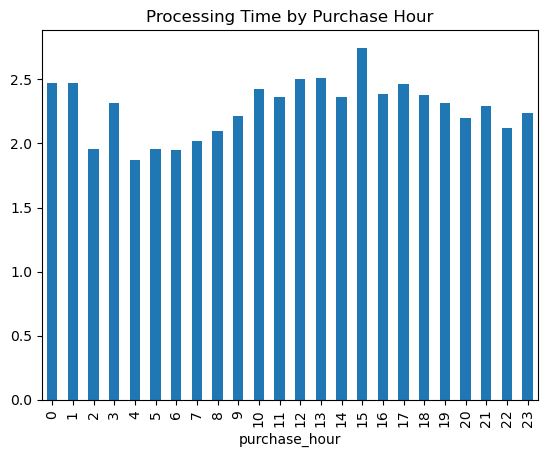

In [34]:
final_df['purchase_hour']=final_df['order_purchase_timestamp'].dt.hour
hourly_processing=final_df.groupby('purchase_hour')['proc_time'].mean()
print("\n--- Average Processing Time by Hour of Purchase ---")
hourly_processing.plot(kind='bar', title='Processing Time by Purchase Hour')

#### Early Arrival Analysis

In [35]:
final_df['delivery_delta']=(final_df['order_estimated_delivery_date']-final_df['order_delivered_customer_date']).dt.days

very_early_orders=final_df[final_df['delivery_delta']>7]
early_arrival_routes=very_early_orders['shipping_route'].value_counts().head(5)
print("\n--- Top 5 Routes with Very Early Arrivals ---")
print(early_arrival_routes)


--- Top 5 Routes with Very Early Arrivals ---
shipping_route
SP -> SP    3065092
SP -> MG    1669161
SP -> RJ    1539446
SP -> RS     498471
PR -> SP     401548
Name: count, dtype: int64


### Review & Satisfaction Insights

#### Seller Speed vs. Review Score

In [36]:
if 'review_score' in final_df.columns:
    seller_reviews = final_df.groupby('seller_id').agg(
        avg_processing_time=('proc_time', 'mean'),
        avg_review_score=('review_score', 'mean')
    ).dropna()
    print("\n--- Correlation between Seller Processing Time and Review Score ---")
    print(seller_reviews[['avg_processing_time', 'avg_review_score']].corr())


--- Correlation between Seller Processing Time and Review Score ---
                     avg_processing_time  avg_review_score
avg_processing_time             1.000000         -0.306424
avg_review_score               -0.306424          1.000000


#### Category vs. Review Score

In [37]:
if 'review_score' in final_df.columns:
    category_reviews = final_df.groupby('product_category_name_english')['review_score'].mean().sort_values()
    print("\n--- Top 5 Lowest-Rated Product Categories ---")
    print(category_reviews.head())


--- Top 5 Lowest-Rated Product Categories ---
product_category_name_english
diapers_and_hygiene    2.976462
home_comfort_2         3.529858
office_furniture       3.576735
party_supplies         3.654703
fixed_telephony        3.705677
Name: review_score, dtype: float64


### Advanced Financial & Inventory Insights

#### Price Volatility Analysis

In [38]:
price_volatility = final_df.groupby('product_id')['price'].agg(['std', 'count']).reset_index()
volatile_products = price_volatility[price_volatility['count'] > 5].sort_values(by='std', ascending=False)
print("--- Top 5 Products with Highest Price Volatility ---")
print(volatile_products.head())

--- Top 5 Products with Highest Price Volatility ---
                             product_id         std  count
17084  8b502ca34e28d30605bc667b965b6abf  404.357107    481
31107  fd8a5b9a8a79d7ba0739d69be5dc5aa1  340.318135    223
20500  a7c87b1bbdd51e0d68b0307cffd03d47  304.646459    493
22803  ba16581014183c8415da15145f3d4c24  241.281451    216
12949  68f3adaef1620e7b0c4c7cd9f78d7ed0  239.651870    297


#### Revenue per Wt/Volm

In [39]:
if 'product_weight_g' in final_df.columns:
    final_df['revenue_per_gram'] = final_df['revenue'] / final_df['product_weight_g']
    product_efficiency = final_df.groupby('product_category_name_english')['revenue_per_gram'].mean().sort_values(ascending=False)
    print("\n--- Top 5 Most Logistically Efficient Categories by Revenue/Gram ---")
    print(product_efficiency.head())


--- Top 5 Most Logistically Efficient Categories by Revenue/Gram ---
product_category_name_english
bed_bath_table                    inf
fashion_bags_accessories     0.590904
construction_tools_safety    0.581302
watches_gifts                0.547748
consoles_games               0.473021
Name: revenue_per_gram, dtype: float64


#### Hero Product

In [40]:
hero_product = final_df['product_id'].value_counts().head(1)
print(f"\n--- The #1 Bestselling Product ID is: ---\n{hero_product}")


--- The #1 Bestselling Product ID is: ---
product_id
aca2eb7d00ea1a7b8ebd4e68314663af    84549
Name: count, dtype: int64


#### Simple Demand Forecasting (Moving Average)

In [41]:
monthly_revenue = final_df.groupby('purchase_month')['revenue'].sum()
monthly_revenue_df = monthly_revenue.to_frame()
monthly_revenue_df['moving_avg_3m'] = monthly_revenue_df['revenue'].rolling(window=3).mean()
print("\n--- Monthly Revenue with 3-Month Moving Average ---")
print(monthly_revenue_df.tail())


--- Monthly Revenue with 3-Month Moving Average ---
                     revenue  moving_avg_3m
purchase_month                             
2018-04         1.790427e+08   1.687048e+08
2018-05         1.752546e+08   1.753924e+08
2018-06         1.629413e+08   1.724129e+08
2018-07         1.559814e+08   1.647258e+08
2018-08         1.543858e+08   1.577695e+08


#### Margin Proxy Analysis

In [42]:
final_df['freight_ratio'] = final_df['freight_value'] / final_df['price']
margin_analysis = final_df.groupby('product_category_name_english')['freight_ratio'].mean().sort_values()
print("\n--- Top 5 Categories with the Best Profit Margin Proxy ---")
print(margin_analysis.head())


--- Top 5 Categories with the Best Profit Margin Proxy ---
product_category_name_english
computers                    0.054923
security_and_services        0.141348
fashion_childrens_clothes    0.143693
watches_gifts                0.166789
home_appliances_2            0.181990
Name: freight_ratio, dtype: float64


### Advanced Logistics & Operations Insights

#### Stuck in Transit

In [43]:
stuck_threshold=final_df['ship_time'].quantile(0.95) 
stuck_orders=final_df[final_df['ship_time'] > stuck_threshold]
print(f"\nFound {len(stuck_orders)} orders with abnormally long shipping times (>{stuck_threshold:.0f} days).")
print("\n--- Top States for Stuck Orders ---")
print(stuck_orders['customer_state'].value_counts().head())


Found 825370 orders with abnormally long shipping times (>22 days).

--- Top States for Stuck Orders ---
customer_state
RJ    341399
MG     69564
SP     69073
RS     63226
BA     61394
Name: count, dtype: int64


#### Top 1% Slowest Deliveries

In [44]:
final_df['delivery_time_days']=(final_df['order_delivered_customer_date']-final_df['order_purchase_timestamp']).dt.days

In [45]:
# --- Outlier Deliveries ---
slowest_1_percent_threshold = final_df['delivery_time_days'].quantile(0.99)
slowest_orders = final_df[final_df['delivery_time_days'] > slowest_1_percent_threshold]
print("\n--- Most Common Categories in the Top 1% Slowest Deliveries ---")
print(slowest_orders['product_category_name_english'].value_counts().head())


--- Most Common Categories in the Top 1% Slowest Deliveries ---
product_category_name_english
bed_bath_table           19974
furniture_decor          12679
health_beauty            11252
sports_leisure           10971
computers_accessories    10474
Name: count, dtype: int64


#### Seller Hub Performance

In [46]:
seller_hubs = final_df.groupby('seller_city').agg(
    total_orders=('order_id', 'nunique'),
    avg_processing_time=('proc_time', 'mean')
)
high_performing_hubs = seller_hubs[seller_hubs['total_orders'] > 100].sort_values(by='avg_processing_time')
print("\n--- Top 5 High-Performing Seller Hubs ---")
print(high_performing_hubs.head())


--- Top 5 High-Performing Seller Hubs ---
                       total_orders  avg_processing_time
seller_city                                             
lages                           118             0.392233
navegantes                      127             0.597496
cajamar                         196             0.667906
santa barbara d'oeste           271             0.749446
sao ludgero                     112             0.760640


#### Last-Mile Delivery Hotspots

In [47]:
late_orders_df = final_df[final_df['is_late'] == 1]
last_mile_hotspots = late_orders_df['customer_zip_code_prefix'].value_counts().head(10)
print("\n--- Top 10 Zip Codes for Late Deliveries ---")
print(last_mile_hotspots)


--- Top 10 Zip Codes for Late Deliveries ---
customer_zip_code_prefix
24220    21774
22793    21574
24230    13224
22790    11679
22631    10816
28300     9312
29101     8834
22775     8602
37200     7656
20540     7566
Name: count, dtype: int64


### Advanced Customer & Seller Insights

#### Customer Lifetime Value (CLV) Proxy

In [48]:
clv = final_df.groupby('customer_unique_id')['revenue'].sum().sort_values(ascending=False)
print("\n--- Top 5 Customers by Lifetime Value ---")
print(clv.head())


--- Top 5 Customers by Lifetime Value ---
customer_unique_id
fd7069cf6891edbf32ba84c9c3f083d4    7462522.80
da122df9eeddfedc1dc1f5349a1a690c    5625721.09
eb53ee675b0c79d66e25fce46957e1fe    3372700.92
85963fd37bfd387aa6d915d8a1065486    2669979.84
763c8b1c9c68a0229c42c9fc6f662b93    2597132.16
Name: revenue, dtype: float64


#### One-Time Buyer Analysis

In [49]:
order_counts = final_df['customer_unique_id'].value_counts()
one_time_buyers = order_counts[order_counts == 1].index
one_time_buyer_df = final_df[final_df['customer_unique_id'].isin(one_time_buyers)]
print("\n--- Top 5 Categories Purchased by One-Time Buyers ---")
print(one_time_buyer_df['product_category_name_english'].value_counts().head())


--- Top 5 Categories Purchased by One-Time Buyers ---
product_category_name_english
health_beauty     16
sports_leisure    14
watches_gifts     14
telephony         12
bed_bath_table    10
Name: count, dtype: int64


#### Seller Sales Concentration (Pareto Principle)

In [50]:
seller_revenue = final_df.groupby('seller_id')['revenue'].sum().sort_values(ascending=False)
top_10_percent_sellers_revenue = seller_revenue.head(int(len(seller_revenue) * 0.1)).sum()
total_seller_revenue = seller_revenue.sum()
percentage_from_top_10_sellers = (top_10_percent_sellers_revenue / total_seller_revenue) * 100
print(f"\nThe top 10% of sellers account for {percentage_from_top_10_sellers:.2f}% of total revenue.")


The top 10% of sellers account for 66.64% of total revenue.


#### Seller Churn Risk (Proxy)

In [51]:
seller_last_sale = final_df.groupby('seller_id')['order_purchase_timestamp'].max()
six_months_ago = final_df['order_purchase_timestamp'].max() - pd.DateOffset(months=6)
churned_sellers = seller_last_sale[seller_last_sale < six_months_ago]
print(f"\nFound {len(churned_sellers)} sellers with no sales in the last 6 months (potential churn).")


Found 764 sellers with no sales in the last 6 months (potential churn).


#### Single-Category vs. Multi-Category Sellers

In [52]:
seller_category_count = final_df.groupby('seller_id')['product_category_name_english'].nunique()
final_df['seller_type'] = final_df['seller_id'].map(lambda x: 'Specialist' if seller_category_count[x] == 1 else 'Generalist')
seller_type_performance = final_df.groupby('seller_type').agg(
    avg_processing_time=('proc_time','mean'),
    avg_revenue_per_order=('revenue','mean')
)
print("\n--- Performance: Specialist vs. Generalist Sellers ---")
print(seller_type_performance)


--- Performance: Specialist vs. Generalist Sellers ---
             avg_processing_time  avg_revenue_per_order
seller_type                                            
Generalist              2.316214             132.561398
Specialist              2.535300             170.481748


#### High-Value vs. High-Frequency

In [53]:
customer_summary = final_df.groupby('customer_unique_id').agg(
    avg_order_value=('revenue', 'mean'),
    frequency=('order_id', 'nunique')
)
print("\n--- Correlation between Average Order Value and Frequency ---")
print(customer_summary[['avg_order_value', 'frequency']].corr())


--- Correlation between Average Order Value and Frequency ---
                 avg_order_value  frequency
avg_order_value          1.00000   -0.01773
frequency               -0.01773    1.00000


### Advanced Customer & Market Dynamics

#### Customer Cohort Analysis (by Acquisition Month)

In [54]:
final_df['acquisition_month'] = final_df.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
cohort_revenue = final_df.groupby('acquisition_month')['revenue'].sum()
print("--- Total Revenue by Customer Acquisition Cohort ---")
print(cohort_revenue.tail())

--- Total Revenue by Customer Acquisition Cohort ---
acquisition_month
2018-04    1.757871e+08
2018-05    1.713176e+08
2018-06    1.585174e+08
2018-07    1.529322e+08
2018-08    1.512264e+08
Freq: M, Name: revenue, dtype: float64


#### Geographic Taste Profile

In [55]:
state_taste = final_df.groupby(['customer_state', 'product_category_name_english']).size().reset_index(name='count')
top_category_per_state = state_taste.loc[state_taste.groupby('customer_state')['count'].idxmax()]
print("\n--- Top Product Category by State ---")
print(top_category_per_state.head(10))


--- Top Product Category by State ---
    customer_state product_category_name_english  count
12              AC               furniture_decor   1172
64              AL                sports_leisure   4325
100             AM                sports_leisure    695
111             AP         computers_accessories    781
164             BA                 health_beauty  44424
218             CE                 health_beauty   7803
274             DF                 health_beauty  10921
305             ES                bed_bath_table  39073
363             GO                bed_bath_table  18838
430             MA         computers_accessories   5502


#### High-Value Customer Profile

In [56]:
customer_value = final_df.groupby('customer_unique_id')['revenue'].sum()
top_5_percent_threshold = customer_value.quantile(0.95)
top_customers = customer_value[customer_value >= top_5_percent_threshold].index
top_customer_df = final_df[final_df['customer_unique_id'].isin(top_customers)]
print("\n--- Most Purchased Categories by Top 5% of Customers ---")
print(top_customer_df['product_category_name_english'].value_counts().head())


--- Most Purchased Categories by Top 5% of Customers ---
product_category_name_english
bed_bath_table           359307
furniture_decor          292796
computers_accessories    243791
sports_leisure           228456
health_beauty            212621
Name: count, dtype: int64


#### Order Hour vs. Order Value


--- Average Order Value by Hour of the Day ---


<Axes: title={'center': 'AOV by Purchase Hour'}, xlabel='purchase_hour'>

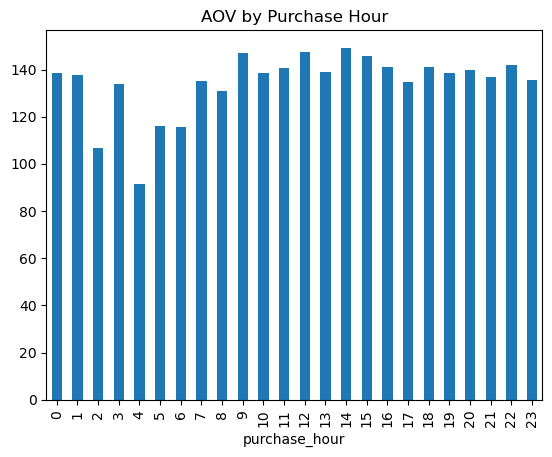

In [57]:
final_df['purchase_hour'] = final_df['order_purchase_timestamp'].dt.hour
hourly_aov = final_df.groupby('purchase_hour')['revenue'].mean()
print("\n--- Average Order Value by Hour of the Day ---")
hourly_aov.plot(kind='bar', title='AOV by Purchase Hour')

#### Customer State Diversity 

In [58]:
state_diversity = final_df.groupby('customer_unique_id')['customer_state'].nunique().sort_values(ascending=False)
print("\n--- Top Customers by Number of States Ordered From ---")
print(state_diversity.head())


--- Top Customers by Number of States Ordered From ---
customer_unique_id
d44ccec15f5f86d14d6a2cfa67da1975    3
62a25a159f9fd2ab7c882d9407f49aa9    2
cdc8b0d152b868db7e28de59f642c94a    2
925751a747a151a7fa97f2f686d028c3    2
9202421110f6a19ddcf0b9b93602a0a1    2
Name: customer_state, dtype: int64


#### First Impression Analysis

In [59]:
first_purchase_df = final_df.sort_values('order_purchase_timestamp').drop_duplicates('customer_unique_id', keep='first')
first_order_late_rate = first_purchase_df['is_late'].mean() * 100
print(f"\nPercentage of customers whose first order was late: {first_order_late_rate:.2f}%")


Percentage of customers whose first order was late: 8.01%


#### Market Saturation Analysis (Proxy)


--- New Customer Acquisition per Month ---


<Axes: title={'center': 'New Customers per Month'}, xlabel='acquisition_month'>

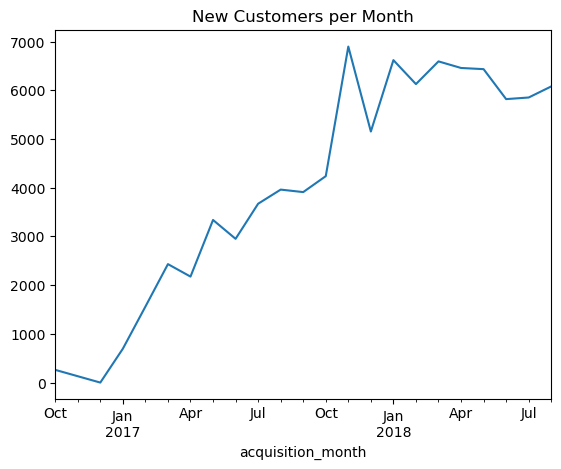

In [60]:
# --- New Customer Acquisition Trend ---
final_df['acquisition_month'] = final_df.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
new_customers_per_month = final_df.drop_duplicates('customer_unique_id', keep='first').groupby('acquisition_month').size()
print("\n--- New Customer Acquisition per Month ---")
new_customers_per_month.plot(kind='line', title='New Customers per Month')

### Deep-Dive Seller & Operations Analytics

####  Seller Dependency Score

In [61]:
seller_dependency = final_df.groupby(['seller_id', 'product_category_name_english']).size().unstack(fill_value=0)
seller_dependency['diversity_score'] = (seller_dependency > 0).sum(axis=1)
print("\n--- Top 5 Most Diverse Sellers ---")
print(seller_dependency.sort_values(by='diversity_score', ascending=False).head()['diversity_score'])


--- Top 5 Most Diverse Sellers ---
seller_id
b2ba3715d723d245138f291a6fe42594    27
4e922959ae960d389249c378d1c939f5    23
955fee9216a65b617aa5c0531780ce60    22
1da3aeb70d7989d1e6d9b0e887f97c23    21
f8db351d8c4c4c22c6835c19a46f01b0    19
Name: diversity_score, dtype: int64


#### New Seller "Incubation Period"

In [62]:
final_df['seller_first_sale'] = final_df.groupby('seller_id')['order_purchase_timestamp'].transform('min')
first_month_sellers_df = final_df[final_df['order_purchase_timestamp'] < (final_df['seller_first_sale'] + pd.DateOffset(months=1))]
new_seller_performance = first_month_sellers_df.groupby('seller_id')['proc_time'].mean()
print(f"\nAverage processing time for sellers in their first month: {new_seller_performance.mean():.2f} days.")


Average processing time for sellers in their first month: 2.92 days.


#### Seller-to-Customer Distance Proxy

In [63]:
final_df['shipping_type'] = np.where(final_df['seller_state'] == final_df['customer_state'], 'Intrastate', 'Interstate')
distance_impact = final_df.groupby('shipping_type')['freight_value'].mean()
print("\n--- Average Freight Cost: Intrastate vs. Interstate ---")
print(distance_impact)


--- Average Freight Cost: Intrastate vs. Interstate ---
shipping_type
Interstate    22.570793
Intrastate    13.759854
Name: freight_value, dtype: float64


#### "Black Swan" Event Analysis

In [64]:
daily_late_deliveries = final_df.groupby(final_df['order_delivered_customer_date'].dt.date)['is_late'].sum()
late_threshold = daily_late_deliveries.quantile(0.99)
black_swan_days = daily_late_deliveries[daily_late_deliveries > late_threshold]
print(f"\n--- Days with Abnormally High Number of Late Deliveries ---")
print(black_swan_days)


--- Days with Abnormally High Number of Late Deliveries ---
order_delivered_customer_date
2017-12-19    15536
2017-12-28    16478
2018-03-23    18256
2018-03-29    17741
2018-04-03    20408
2018-04-04    15950
2018-04-18    15848
Name: is_late, dtype: int32


#### Logistics Chain Efficiency

In [65]:
final_df['total_delivery_chain_time'] = final_df['proc_time'] + final_df['ship_time']
total_processing = final_df['proc_time'].sum()
total_shipping = final_df['ship_time'].sum()
processing_percentage = (total_processing / (total_processing + total_shipping)) * 100
print(f"\n{processing_percentage:.2f}% of the total delivery lifecycle is spent on seller processing.")


21.81% of the total delivery lifecycle is spent on seller processing.


#### Correlation of Seller Order Volume and Performance

In [66]:
# --- Seller Volume vs. Performance ---
seller_summary = final_df.groupby('seller_id').agg(
    total_orders=('order_id', 'nunique'),
    avg_processing_time=('proc_time', 'mean')
)
print("\n--- Correlation between Seller Order Volume and Processing Time ---")
print(seller_summary[['total_orders', 'avg_processing_time']].corr())


--- Correlation between Seller Order Volume and Processing Time ---
                     total_orders  avg_processing_time
total_orders             1.000000            -0.029194
avg_processing_time     -0.029194             1.000000


#### Order Combination Analysis

In [67]:
# --- Items per Order ---
items_per_order = final_df.groupby('order_id').size()
print(f"\nAverage number of items per order: {items_per_order.mean():.2f}")


Average number of items per order: 183.75


### Strategic Financial & Product Insights

#### "Return to Sender" Risk (Proxy)

In [68]:
return_risk_threshold = final_df['ship_time'].quantile(0.98) 
return_risk_orders = final_df[final_df['ship_time'] > return_risk_threshold]
print(f"\nFound {len(return_risk_orders)} orders at high risk of being rejected due to long shipping times.")


Found 337104 orders at high risk of being rejected due to long shipping times.


#### Monthly Active Customers (MAC)


--- Monthly Active Customers ---


<Axes: title={'center': 'Monthly Active Customers'}, xlabel='purchase_month'>

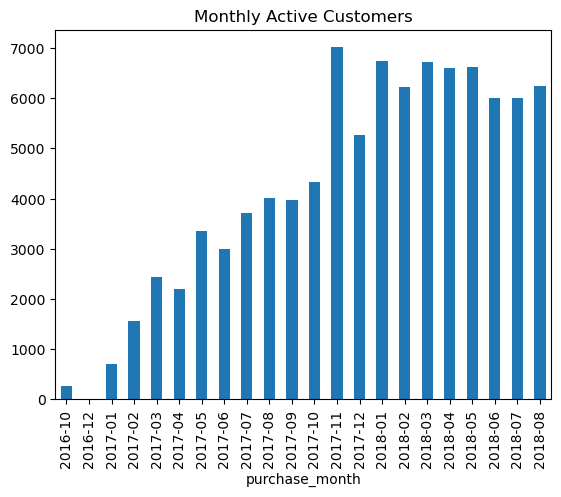

In [69]:
monthly_active_customers = final_df.groupby('purchase_month')['customer_unique_id'].nunique()
print("\n--- Monthly Active Customers ---")
monthly_active_customers.plot(kind='bar', title='Monthly Active Customers')

#### Product "Stickiness" (Repurchase Rate)

In [70]:
repeat_purchase_df = final_df[final_df.duplicated(subset=['customer_unique_id', 'product_category_name_english'], keep=False)]
category_stickiness = repeat_purchase_df['product_category_name_english'].value_counts()
print("\n--- Top 5 'Stickiest' Product Categories ---")
print(category_stickiness.head())


--- Top 5 'Stickiest' Product Categories ---
product_category_name_english
bed_bath_table           1854714
health_beauty            1409263
furniture_decor          1383969
sports_leisure           1361387
computers_accessories    1228180
Name: count, dtype: int64


#### Revenue per Customer vs. Orders per Customer

In [71]:
customer_summary = final_df.groupby('customer_unique_id').agg(
    total_revenue=('revenue', 'sum'),
    total_orders=('order_id', 'nunique')
)
print("\n--- Correlation between Total Revenue and Order Count per Customer ---")
print(customer_summary.corr())


--- Correlation between Total Revenue and Order Count per Customer ---
               total_revenue  total_orders
total_revenue       1.000000      0.087055
total_orders        0.087055      1.000000


#### Seasonal Product Analysis

In [72]:
final_df['purchase_month_num'] = final_df['order_purchase_timestamp'].dt.month
seasonal_sales = pd.crosstab(final_df['product_category_name_english'], final_df['purchase_month_num'], normalize='index') * 100
# Example: Find categories that peak in December (Month 12)
print("--- Top 5 Categories with Sales Peaks in December ---")
print(seasonal_sales.sort_values(by=12, ascending=False).head(5)[12])

--- Top 5 Categories with Sales Peaks in December ---
product_category_name_english
diapers_and_hygiene                  32.328062
furniture_mattress_and_upholstery    14.714313
christmas_supplies                   12.220189
flowers                              12.200034
toys                                 11.076502
Name: 12, dtype: float64


#### Order Value Segmentation

In [73]:
final_df['order_value_tier'] = pd.cut(final_df['revenue'], bins=[0, 50, 200, 5000], labels=['Small', 'Medium', 'Large'])
value_tier_performance = final_df.groupby('order_value_tier',observed=False).agg(
    avg_delivery_time=('delivery_time_days', 'mean'),
    late_rate=('is_late', 'mean')
)
print("\n--- Delivery Performance by Order Value Tier ---")
print(value_tier_performance)


--- Delivery Performance by Order Value Tier ---
                  avg_delivery_time  late_rate
order_value_tier                              
Small                     10.144114   0.065066
Medium                    11.909206   0.073525
Large                     13.122127   0.086224


#### "Dead on Arrival" Seller Analysis

In [74]:
seller_lifespan = final_df.groupby('seller_id')['order_purchase_timestamp'].agg(['min', 'max'])
seller_lifespan['active_days'] = (seller_lifespan['max'] - seller_lifespan['min']).dt.days
short_lived_sellers = seller_lifespan[seller_lifespan['active_days'] < 30] # Active for less than a month
print(f"\nFound {len(short_lived_sellers)} sellers who were active for less than 30 days.")


Found 823 sellers who were active for less than 30 days.


#### Payment Installment Analysis

In [75]:
if 'payment_installments' in final_df.columns:
    installment_analysis = final_df.groupby('payment_installments')['price'].mean()
    print("\n--- Average Item Price by Number of Payment Installments ---")
    print(installment_analysis)


--- Average Item Price by Number of Payment Installments ---
payment_installments
0      41.767106
1      91.344944
2     100.501452
3     108.807847
4     127.654768
5     136.692813
6     151.545958
7     140.001947
8     230.433464
9     148.566118
10    293.344237
11     95.129397
12    229.098322
13    107.446052
14    146.153426
15    270.445925
16    165.966797
17    150.171645
18    422.110647
20    395.041765
21    185.499626
22    209.990000
23    216.000000
24    195.613198
Name: price, dtype: float64


#### Golden Hour Analysis

In [76]:
final_df['day_hour'] = final_df['order_purchase_timestamp'].dt.strftime('%A-%H')
golden_hour = final_df['day_hour'].value_counts().head(1)
print(f"\n--- The 'Golden Hour' with the most orders is: ---\n{golden_hour}")


--- The 'Golden Hour' with the most orders is: ---
day_hour
Tuesday-14    209667
Name: count, dtype: int64


#### Freight Cost as a Percentage of Revenue

In [77]:
total_revenue=final_df['revenue'].sum()
total_freight_cost=final_df['freight_value'].sum()
freight_to_revenue_ratio=(total_freight_cost/total_revenue)*100
print(f"\nFreight costs make up {freight_to_revenue_ratio:.2f}% of total gross revenue.")


Freight costs make up 13.98% of total gross revenue.


#### Cross-State Commerce Matrix

In [78]:
cross_state_matrix = pd.crosstab(final_df['seller_state'], final_df['customer_state'])
cross_state_matrix

customer_state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
seller_state,,,,,,,,,,,,,,,,,,,,,
AM,0,65,0,0,0,0,0,0,0,75,...,0,0,0,0,0,0,0,0,0,0
BA,28,1130,25,99,8919,842,907,1943,797,998,...,1325,19880,358,205,23,5080,2344,436,24729,151
CE,0,66,33,0,58,399,65,386,67,96,...,438,2590,5,53,0,131,266,350,2381,0
DF,164,231,0,0,3070,944,2682,4609,2031,942,...,4047,25433,273,0,0,4323,2803,217,47598,1910
ES,0,0,0,0,2833,142,55,1913,141,259,...,1828,13438,92,18,0,2277,2845,0,16739,296
GO,15,233,103,140,850,482,1390,720,1476,1055,...,2415,14910,26,124,0,1344,2174,0,21755,445
MA,164,659,58,85,976,408,1342,3008,1102,812,...,1386,10340,121,0,0,2284,3834,336,17700,24
MG,1038,2580,523,235,52037,4473,9500,27674,9769,4785,...,53007,307728,1543,1741,96,47252,42327,3251,394430,1220
MS,144,0,0,0,994,0,153,0,62,0,...,385,1887,0,0,0,140,45,0,2286,0


#### Review Score Volatility

In [79]:

review_volatility = final_df.groupby('product_category_name_english')['review_score'].std().sort_values(ascending=False)
print("\n--- Top 5 Categories with the Most Polarized Reviews ---")
print(review_volatility.head())


--- Top 5 Categories with the Most Polarized Reviews ---
product_category_name_english
diapers_and_hygiene      1.715190
party_supplies           1.676989
fashion_male_clothing    1.658973
furniture_bedroom        1.637776
audio                    1.552561
Name: review_score, dtype: float64


#### Time-to-Approve by Payment Type

In [80]:

final_df['approval_lag_hours']=(final_df['order_approved_at']-final_df['order_purchase_timestamp']).dt.total_seconds()/3600
approval_time=final_df.groupby('payment_type')['approval_lag_hours'].mean().sort_values(ascending=False)
print("\n--- Average Time-to-Approve by Payment Method (in Hours) ---")
print(approval_time)


--- Average Time-to-Approve by Payment Method (in Hours) ---
payment_type
boleto         32.930723
voucher         9.022036
debit_card      7.912455
credit_card     4.383903
Name: approval_lag_hours, dtype: float64


#### Compound Monthly Growth Rate (CMGR)

In [81]:
monthly_revenue = final_df.groupby('purchase_month')['revenue'].sum()
if len(monthly_revenue) > 1:
    first_month_rev = monthly_revenue.iloc[0]
    last_month_rev = monthly_revenue.iloc[-1]
    num_periods = len(monthly_revenue) - 1
    cmgr = ((last_month_rev / first_month_rev) ** (1 / num_periods)) - 1
    print(f"\nCompound Monthly Growth Rate (CMGR) for revenue is: {cmgr:.2%}")


Compound Monthly Growth Rate (CMGR) for revenue is: 15.46%


### Advanced Inventory & Product Strategy

#### Product Lifecycle Stage Analysis (Proxy)

In [82]:
final_df['purchase_quarter'] = final_df['order_purchase_timestamp'].dt.to_period('Q')
quarterly_sales = final_df.groupby(['product_id', 'purchase_quarter'])['order_id'].nunique().unstack(fill_value=0)

if quarterly_sales.shape[1] > 2:
    quarterly_sales['growth_metric'] = quarterly_sales.iloc[:, -1] - quarterly_sales.iloc[:, -2]
    print("--- Top 5 Products in 'Growth' Stage ---")
    print(quarterly_sales.sort_values(by='growth_metric', ascending=False).head()['growth_metric'])

--- Top 5 Products in 'Growth' Stage ---
product_id
e7cc48a9daff5436f63d3aad9426f28b    59
73326828aa5efe1ba096223de496f596    52
64b4f32393cbf55be791078e7a2adca0    23
2bd9b51a9ab079e095aca987845d3266    21
2ff995aead9c63a1f37a07b3664ead37    19
Name: growth_metric, dtype: int64


#### Return on Inventory Investment (ROII) Proxy

In [83]:
final_df['profit_proxy'] = final_df['price'] - final_df['freight_value']
roii_proxy = final_df.groupby('product_category_name_english').agg(
    total_profit=('profit_proxy', 'sum'),
    total_cost=('price', 'sum')
)
roii_proxy['roii'] = roii_proxy['total_profit'] / roii_proxy['total_cost']
print("\n--- Top 5 Categories by Return on Inventory Investment (Proxy) ---")
print(roii_proxy.sort_values(by='roii', ascending=False).head()['roii'])


--- Top 5 Categories by Return on Inventory Investment (Proxy) ---
product_category_name_english
computers                                0.957124
small_appliances_home_oven_and_coffee    0.939246
fixed_telephony                          0.932487
agro_industry_and_commerce               0.929681
small_appliances                         0.923528
Name: roii, dtype: float64


#### Cannibalization Effect (Proxy)

In [84]:
# Analyze the sales trend of the #2 product in a category after the #1 product was introduced.
category = 'sports_leisure'
category_df = final_df[final_df['product_category_name_english'] == category]
top_products = category_df['product_id'].value_counts().index[:2]
if len(top_products) == 2:
    prod1_intro_date = category_df[category_df['product_id'] == top_products[0]]['order_purchase_timestamp'].min()
    prod2_sales = category_df[category_df['product_id'] == top_products[1]].set_index('order_purchase_timestamp').resample('ME')['order_id'].nunique()
    print(f"\n--- Sales of #2 product in '{category}' after #1 was introduced ---")
    print(prod2_sales[prod2_sales.index > prod1_intro_date])


--- Sales of #2 product in 'sports_leisure' after #1 was introduced ---
order_purchase_timestamp
2017-09-30    5
2017-10-31    1
2017-11-30    1
2017-12-31    3
2018-01-31    4
2018-02-28    4
2018-03-31    4
2018-04-30    0
2018-05-31    4
2018-06-30    3
2018-07-31    7
2018-08-31    5
Freq: ME, Name: order_id, dtype: int64


#### Inventory Turnover Rate (Proxy)

In [85]:
# Proxy: Total Sales / (Average number of unique products sold per month)
total_sales = final_df['product_id'].count()
avg_monthly_unique_products = final_df.groupby('purchase_month')['product_id'].nunique().mean()
inventory_turnover_proxy = total_sales / avg_monthly_unique_products
print(f"\nPlatform-wide inventory turnover proxy: {inventory_turnover_proxy:.2f}")


Platform-wide inventory turnover proxy: 6397.24


### Granular Logistics & Network Optimization

#### "First Mile" Performance Analysis

In [86]:
final_df['first_mile_hours'] = (final_df['order_delivered_carrier_date'] - final_df['order_approved_at']).dt.total_seconds() / 3600
print(f"\nAverage 'First Mile' time: {final_df['first_mile_hours'].mean():.2f} hours.")


Average 'First Mile' time: 68.76 hours.


#### "Last Mile" Bottleneck Identification (Proxy)

In [87]:
state_avg_shipping=final_df.groupby('customer_state')['ship_time'].transform('mean')
final_df['last_mile_delay_proxy']=final_df['ship_time'] - state_avg_shipping
city_bottlenecks=final_df.groupby('customer_city')['last_mile_delay_proxy'].mean().sort_values(ascending=False)
print("\n--- Top 5 Cities with Potential 'Last Mile' Delays ---")
print(city_bottlenecks.head())


--- Top 5 Cities with Potential 'Last Mile' Delays ---
customer_city
novo brasil            133.596498
capinzal do norte       86.702227
adhemar de barros       84.271246
santa cruz de goias     72.034453
arace                   69.346498
Name: last_mile_delay_proxy, dtype: float64


#### Logistics Hub "Gravity" Analysis

In [88]:
hub_gravity=final_df.groupby('seller_city')['customer_city'].nunique().sort_values(ascending=False)
print("\n--- Top 5 Seller Cities by Customer Reach ---")
print(hub_gravity.head())


--- Top 5 Seller Cities by Customer Reach ---
seller_city
sao paulo         2425
ibitinga          1236
santo andre        771
curitiba           715
belo horizonte     684
Name: customer_city, dtype: int64


#### Perfect Order Rate

In [89]:

perfect_order = (
        (final_df['approval_lag_hours'] <= 24) &
        (final_df['proc_time'] <= 2) &
        (final_df['is_late'] == 0) &
        (final_df['review_score'] >= 4)
    )
perfect_order_rate = perfect_order.mean() * 100
print(f"\n'Perfect Order' Rate: {perfect_order_rate:.2f}%")


'Perfect Order' Rate: 43.70%


### Seller Ecosystem & Performance Dynamics

#### Seller-to-Seller Network Analysis (Proxy)

In [90]:
seller_details = final_df[['seller_id', 'seller_city', 'product_category_name_english']].drop_duplicates()
competitor_pairs = pd.merge(seller_details, seller_details, on=['seller_city', 'product_category_name_english'])
competitor_pairs = competitor_pairs[competitor_pairs['seller_id_x'] != competitor_pairs['seller_id_y']]
print(f"\nFound {len(competitor_pairs)} potential competitor pairs.")


Found 92326 potential competitor pairs.


#### Top Seller "Market Share" by Category

In [91]:
category = 'auto'
category_df = final_df[final_df['product_category_name_english'] == category]
seller_revenue_in_cat = category_df.groupby('seller_id')['revenue'].sum()
top_3_seller_revenue = seller_revenue_in_cat.nlargest(3).sum()
total_cat_revenue = category_df['revenue'].sum()
market_share = (top_3_seller_revenue / total_cat_revenue) * 100
print(f"\nIn '{category}', the top 3 sellers capture {market_share:.2f}% of the revenue.")


In 'auto', the top 3 sellers capture 22.13% of the revenue.


### Strategic Customer & Financial Insights

#### Anomaly Detection for Fraud (Z-Score)

In [92]:
from scipy.stats import zscore

final_df['price_zscore'] = zscore(final_df['price'])
potential_fraud = final_df[abs(final_df['price_zscore']) > 3] # Z-score > 3 is a common threshold
print(f"\nFound {len(potential_fraud)} orders with potentially anomalous prices.")


Found 309190 orders with potentially anomalous prices.


#### "Saved" Orders Analysis

In [93]:
slow_processing_threshold = final_df['proc_time'].quantile(0.75)
fast_shipping_threshold = final_df['ship_time'].quantile(0.25)
saved_orders = final_df[
    (final_df['proc_time'] > slow_processing_threshold) &
    (final_df['ship_time'] < fast_shipping_threshold) &
    (final_df['is_late'] == 0)
]
print(f"\nFound {len(saved_orders)} orders that were 'saved' by fast shipping.")


Found 785461 orders that were 'saved' by fast shipping.


In [94]:
final_df['return_on_freight'] = np.where(
	final_df['freight_value'] != 0,
	final_df['profit_proxy'] / final_df['freight_value'],
	np.nan
)
high_freight_orders = final_df[final_df['freight_value'] > final_df['freight_value'].quantile(0.75)]
print(f"Average 'Return on Freight' for high-cost shipping orders: {high_freight_orders['return_on_freight'].mean():.2f}")

Average 'Return on Freight' for high-cost shipping orders: 5.58


# Further EDA is in Part 2...